### Importing the libraries

In [3]:
!pip install ppscore
!pip install --upgrade pandas
!pip install --upgrade numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import imblearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import pandas as pd
import ppscore as pps
from progressbar import ProgressBar
pbar = ProgressBar()  #for showing iteration progress

from sklearn import metrics
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as pline
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score,auc, roc_curve, average_precision_score
from sklearn.metrics import mean_squared_log_error
from math import sqrt
from sklearn.model_selection import train_test_split
from IPython.display import Image  
from sklearn import tree
from os import system

### Importing the dataset

In [5]:
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")
sample  = pd.read_csv("sampleSubmission.csv")

In [ ]:
train.head(5)

In [ ]:
train.info()

In [ ]:
test.head(5)

In [ ]:
test.info()

In [6]:
# Add identifying column
train['set'] = 'train'
test['set'] = 'test'
test['churn'] = np.nan

# Append the dataframes
df_app = train.append(test, ignore_index = True)

In [ ]:
df_app.describe().T   # five point summary of the continuous attributes

In [8]:
df_app.churn.value_counts()

no     3652
yes     598
Name: churn, dtype: int64

In [ ]:
# y = train.churn
# train.drop('churn', axis=1, inplace=True)

In [ ]:
# train = train.reset_index(drop=True)
# test = test.reset_index(drop=True)
# train

### Visualising the data

In [ ]:
plt.figure(figsize=(25,25))
sns.barplot(x="total_night_minutes",y="churn", data=df_train)

#-----------------------------------
plt.figure(figsize= (20,15))
plt.subplot(3,1,1)
sns.boxplot(x= df.bmi, color='lightblue')

plt.subplot(3,1,2)
sns.boxplot(x= df.age, color='lightblue')

plt.subplot(3,1,3)
sns.boxplot(x= df.charges, color='lightblue')

plt.show()

In [ ]:
#-----------------------------------------
#To check for data skew and for outliers
train.skew()

#To check correlations between the features
plt.figure(figsize=(15,10))
sns.heatmap(train.corr(), annot = True)

#To check the distribution of the features and check for outliers
train.plot(kind='density', subplots =True, layout=(3,3),sharex=False, figsize=(15,10))
plt.show()

#Checking for correlations 
sns.pairplot(train, diag_kind= "kde")  #pairplot
plt.show()

### Checking for outliers in the data

In [ ]:
plt.figure(figsize= (20,15))
plt.subplot(3,1,1)
sns.boxplot(x= df.column_name, color='lightblue')

plt.subplot(3,1,2)
sns.boxplot(x= df.column_name, color='lightblue')

plt.subplot(3,1,3)
sns.boxplot(x= df.column_name, color='lightblue')

plt.show()

### Removing duplicate rows from data if present :


In [ ]:
def remove_duplicate(data):
    
    print("BEFORE REMOVING DUPLICATES - No. of Rows = ",data.shape[0])
    data.drop_duplicates(keep="first", inplace=True) 
    print("AFTER REMOVING DUPLICATES  - No. of Rows = ",data.shape[0])
    
    return data

# Remove Duplicates from data :

df_app = remove_duplicate(df_app)
train = remove_duplicate(train)
test = remove_duplicate(test)

BEFORE REMOVING DUPLICATES - No. of Rows =  5000
AFTER REMOVING DUPLICATES  - No. of Rows =  5000


### Treating Missing Values

For Categorical variables, it's best to perform 'mode' replacement. For numeric values, we shall be performing 'permanent mean matching' (pmm).

In [ ]:
df_app.isna().sum()

In [ ]:
def fill_missing_values(data, fill_value, fill_types, cat_columns, int_columns):
    
    print("Missing Values BEFORE REMOVAL in data")
    display(data.isnull().sum())
    for column in cat_columns :
        
        data[ column ].fillna(data[column].mode(), inplace=True)

    for column in int_columns :

        
        # Fill Missing Values with Specific Value :
        if "Value_Fill" in fill_types :
            data[ column ] = data[ column ].fillna(fill_value)
#             print("Value_Fill")

        # Fill Missing Values with Forward Fill  (Previous Row Value as Current Row in Table) :
        if "Forward_Fill" in fill_types :
            data[ column ] = data[ column ].ffill(axis = 0)
            #df[column] = df.groupby('another_category')[column].ffill(limit = 1)
#             print("Forward_Fill")

        # Fill Missing Values with Backward Fill (Next Row Value as Current Row in Table) :
        if "Backward_Fill" in fill_types :
            data[ column ] = data[ column ].bfill(axis = 0)
#             print("Backward_Fill")
    
    print("Missing Values AFTER REMOVAL in ",dataframe_name," data")
    display(data.isnull().sum())
    
    return data

cat_columns = [ "column_names"]
int_columns = [ "column_names"]
fill_types = [ "Forward_Fill"]
fill_value = 0

df = fill_missing_values(df, fill_value, fill_types, cat_columns, int_columns ])

### Converting object data types into categories

In [ ]:
df_app.dtypes

In [ ]:
datasets = [df_app]

for data in datasets:
 for feature in data.columns: # Loop through all columns in the dataframe
    if data[feature].dtype == 'object': # Only apply for columns with categorical strings
        data[feature] = pd.Categorical(data[feature])# Replace strings with an integer
df_app.info()

### Encoding categorical data

If there are ordinal categorical data (there is an order to it) then we need to manually label them ordinally (1,2,3..) so as to keep the variance.

If there are categorical variables which do not have an order then it's best to one hot encode them (IF THEY ARE NOT TOO MANY), or label encode them in case of many categories.

In [10]:
#those features with order in their categories 
replaceStruct = {
                "international_plan":     {"no": 0, "yes": 1},
                "voice_mail_plan": {"no": 0, "yes": 1},
                 "churn": {"no": -1, "yes": 1}
                    }

#those features with NO order in their categories                   
oneHotCols=["area_code"]

df_app=df_app.replace(replaceStruct)
df_app=pd.get_dummies(df_app, columns=oneHotCols)

#-------------------------------------------------------------------------------

# LabelEncoding columns (In case of encoding an unordered column with a large number of unique values)

labelColumns = ["state"]
le = preprocessing.LabelEncoder()

datasets = [df_app]

for data in datasets:
  for column in labelColumns:
      data[column] = data[column].astype('category')
      data[column + '_cat'] = data[column].cat.codes

df_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   state                          5000 non-null   category
 1   account_length                 5000 non-null   int64   
 2   international_plan             5000 non-null   int64   
 3   voice_mail_plan                5000 non-null   int64   
 4   number_vmail_messages          5000 non-null   int64   
 5   total_day_minutes              5000 non-null   float64 
 6   total_day_calls                5000 non-null   int64   
 7   total_day_charge               5000 non-null   float64 
 8   total_eve_minutes              5000 non-null   float64 
 9   total_eve_calls                5000 non-null   int64   
 10  total_eve_charge               5000 non-null   float64 
 11  total_night_minutes            5000 non-null   float64 
 12  total_night_calls              500

### Assigning feature and target variables

In [ ]:
# X = dataset.iloc[:, :-1].values
# y = dataset.iloc[:, -1].values

# X = df.drop("target" , axis=1)
# y = df.pop("target")

### Scaling and Normalising the data
Seperate the response variable before performing scaling

In [ ]:
df_app.columns

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#Standardisation is generally performed to take care of outliers, if data has outliers then it's used preferably

scaler = MinMaxScaler()
std_scaler = StandardScaler()

scale_columns = ['account_length', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_eve_charge', 'total_night_minutes', 'total_night_calls',
       'total_night_charge', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'number_customer_service_calls',
        'state_cat']

datasets = [df_app]

for data in datasets:
  for column in scale_columns:
    data[column] = scaler.fit_transform(data[column].to_numpy().reshape(-1, 1))

In [ ]:
df_app.head(5)

In [ ]:
df_app.describe().T

### Feature Engineering

In [ ]:
##correlation matrix. Feature elimination based on multicollinearity
corr=train.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(15,10))
sns.heatmap(corr,vmin=-1,cmap='coolwarm',annot=True,mask=mask);

#### Handling dates and times and seperating them

In [ ]:
# df['DATE'] = pd.to_datetime(df['DATE'], format="%m/%d/%Y %H:%M")

# hour=[]
# day=[]
# dayofweek=[]
# month=[]
# weekday=[]
# for x in df['DATE']:
#     hour.append(x.hour)
#     day.append(x.day)
#     dayofweek.append(x.dayofweek)
#     month.append(x.month)
#     weekday.append(calendar.day_name[dayofweek[-1]])
# df['HOUR']=hour
# df['DAY']=day
# df['DAY_OF_WEEK']=dayofweek
# df['MONTH']=month
# df['WEEKDAY']=weekday

#### Using Corr matrix and PPS Score to check for both linear and non linear relationship between the features

In [ ]:
###pps scores detect all types of relationship present in between variables. But if only linear relationship is of interest pearson corr matrix should still be used
df_pps = df_app.drop('state', axis = 1)
# train_pps = train.drop('account_length', axis = 1)
pps_score=pps.matrix(pd.DataFrame(df_pps))

In [ ]:
pps_score

In [ ]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(pps_score, cmap="Reds", linewidths=3, annot=True,ax=ax,annot_kws={"fontsize":10})

### Splitting the dataset into the Training set and Test set

In [12]:
df_new = df_app.drop('state', axis = 1)

In [ ]:
train_new = df_new[df_new['set']== 'train']
test_new = df_new[df_new['set']== 'test']
y = train_new.churn
train_new.drop(['id','set', 'churn'], axis = 1, inplace = True)
test_new.drop(['id','churn', 'set'], axis = 1, inplace= True)

In [ ]:
train_new.info()

In [ ]:
test_new.info()

In [ ]:
y.value_counts()

-1.0    3652
 1.0     598
Name: churn, dtype: int64

### Performing over and under sampling in case of imbalanced binary datasets

In [16]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('o', over), ('u', under)]
pipeline = pline(steps=steps)

# transform the dataset
train_samp, y_samp = pipeline.fit_resample(train_new, y)

In [ ]:
train_samp.info()

In [ ]:
train_samp.head(10)

In [18]:
y_samp.value_counts()

-1.0    2920
 1.0    1460
Name: churn, dtype: int64

In [19]:
#If over and under sampling is required
train_new,y = train_samp, y_samp
y.value_counts()

-1.0    2920
 1.0    1460
Name: churn, dtype: int64

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(train_new, y, test_size = 0.3, random_state = 0)

### Creating a Baseline ML Model

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
import xgboost

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score #for imbalanced binary classification

#### Dropping features based on FE

In [21]:
#Dropping features after feature engineering
train_new.drop(['voice_mail_plan','area_code_area_code_415', 'area_code_area_code_510'], axis = 1, inplace=True)

In [22]:
test_new.drop(['voice_mail_plan','area_code_area_code_415', 'area_code_area_code_510'], axis = 1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Defining a base DT model

In [ ]:
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_new, y, test_size = 0.3, random_state = 0)

#### Plotting optimal tree depth

In [ ]:
#Creating a regularised decision tree by pruning
depth = []
test_score = []

for i in range(3,11):
  dTreeR = DecisionTreeClassifier(criterion = 'gini', max_depth = i, random_state=1)
  dTreeR.fit(X_train, y_train)
  #dTreeR.score(X_train, y_train))
  depth.append(i)
  test_score.append(dTreeR.score(X_test, y_test))

sns.set()
plt.plot(depth, test_score) #Plotting depth vs. score

#### Using Stratified K-Fold CV

In [ ]:
train_new.info()

In [35]:
#Initializing metric lists

model_name = []
avg_acc = []
max_acc = []
AUC_ROC = []
AUC_PR = []

##StratifiedKFold CV
##Decision Tree
l=[]
name = 'DecisionTree'
rocauc_score = []
prc_score = []

setused=train_new
target=y
kfold, scores = StratifiedKFold(n_splits=50), list()
for train, test in pbar(kfold.split(setused,target)):
    x_train, x_test = setused.values[train], setused.values[test]
    y_train, y_test = target.values[train], target.values[test] 
    model = DecisionTreeClassifier(criterion = 'gini', max_depth = 7, random_state=1) #using optimal tree depth
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    feature_importances = pd.DataFrame(model.feature_importances_,
                                       index = setused.columns,
                                        columns=['importance'])
    sum=feature_importances.values
    l.append(sum)
    score = balanced_accuracy_score(preds, y_test)
    scores.append(score)
    roc_auc = roc_auc_score(y_test,model.predict_proba(x_test)[:, 1])
    rocauc_score.append(roc_auc)
    prc = average_precision_score(y_test,model.predict_proba(x_test)[:, 1], pos_label= 1)
    prc_score.append(prc)

mean_acc = np.sum(scores)/len(scores)
max_accuracy = max(scores)
rocauc = np.array(rocauc_score).mean()
aucpr = np.array(prc_score).mean()

model_name.append(name)
avg_acc.append(mean_acc)
max_acc.append(max_accuracy)
AUC_ROC.append(rocauc)
AUC_PR.append(aucpr)

print('\n'+ str(model) + "Average scores are: ", mean_acc)
print(str(model) + "Max score is: ", max_accuracy,'\n')
print('ROC_AUC - CV Score: {}'.format(rocauc))
print('PRC - Score: {}'.format(aucpr),'\n')
print(pd.DataFrame(model.feature_importances_*100, columns = ["Importance"], 
                   index = train_new.columns).sort_values('Importance', ascending=False))


| |    #                                            | 219 Elapsed Time: 0:13:43


DecisionTreeClassifier(max_depth=7, random_state=1)Average scores are:  0.9244983542553037
DecisionTreeClassifier(max_depth=7, random_state=1)Max score is:  0.9754098360655737 

ROC_AUC - CV Score: 0.8977022746662905
PRC - Score: 0.8594699817197431 

                               Importance
total_day_minutes               24.932287
number_customer_service_calls   19.787768
international_plan              15.085456
total_intl_charge                7.358898
total_eve_minutes                6.232293
total_eve_charge                 5.459852
number_vmail_messages            5.317763
total_day_charge                 5.121178
total_intl_calls                 5.040816
total_night_charge               1.611951
total_night_minutes              1.139837
total_day_calls                  0.903762
state_cat                        0.656368
total_intl_minutes               0.486028
total_eve_calls                  0.295049
total_night_calls                0.285433
account_length                   0

### Ensemble Model

In [25]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import plot_importance,LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
print(train_new.shape , y.shape)

In [36]:
#KNN Classifier
knn = KNeighborsClassifier()
name = 'KNN'
l=[]
rocauc_score = []
prc_score = []
setused=train_new
target=y
kfold, scores = StratifiedKFold(n_splits=10), list()
for train, test in pbar(kfold.split(setused,target)):
    x_train, x_test = setused.values[train], setused.values[test]
    y_train, y_test = target.values[train], target.values[test] 
    model = knn
    model.fit(x_train, y_train)
    preds = model.predict(x_test)   
    score = balanced_accuracy_score(preds, y_test)
    scores.append(score)
    roc_auc = roc_auc_score(y_test,model.predict_proba(x_test)[:, 1])
    rocauc_score.append(roc_auc)
    prc = average_precision_score(y_test,model.predict_proba(x_test)[:, 1], pos_label= 1)
    prc_score.append(prc)

mean_acc = np.sum(scores)/len(scores)
max_accuracy = max(scores)
rocauc = np.array(rocauc_score).mean()
aucpr = np.array(prc_score).mean()

model_name.append(name)
avg_acc.append(mean_acc)
max_acc.append(max_accuracy)
AUC_ROC.append(rocauc)
AUC_PR.append(aucpr)

print('\n'+ str(model) + "Average scores are: ", mean_acc)
print(str(model) + "Max score is: ", max_accuracy,'\n')
print('ROC_AUC - CV Score: {}'.format(rocauc))
print('PRC - Score: {}'.format(aucpr),'\n')

| |                                              #  | 229 Elapsed Time: 0:13:48


KNeighborsClassifier()Average scores are:  0.864214837791882
KNeighborsClassifier()Max score is:  0.8885265568764315 

ROC_AUC - CV Score: 0.9464674422968662
PRC - Score: 0.8695117160827026 



In [37]:
#Bagging classifier
bgcl = BaggingClassifier(n_estimators=100,random_state=1)
name = 'Bagging'
l=[]
setused=train_new
target=y
kfold, scores = StratifiedKFold(n_splits=10), list()
for train, test in pbar(kfold.split(setused,target)):
    x_train, x_test = setused.values[train], setused.values[test]
    y_train, y_test = target.values[train], target.values[test] 
    model = bgcl
    model.fit(x_train, y_train)
    preds = model.predict(x_test)   
    score = balanced_accuracy_score(preds, y_test)
    scores.append(score)
    roc_auc = roc_auc_score(y_test,model.predict_proba(x_test)[:, 1])
    rocauc_score.append(roc_auc)
    prc = average_precision_score(y_test,model.predict_proba(x_test)[:, 1], pos_label= 1)
    prc_score.append(prc)

mean_acc = np.sum(scores)/len(scores)
max_accuracy = max(scores)
rocauc = np.array(rocauc_score).mean()
aucpr = np.array(prc_score).mean()

model_name.append(name)
avg_acc.append(mean_acc)
max_acc.append(max_accuracy)
AUC_ROC.append(rocauc)
AUC_PR.append(aucpr)

print('\n'+ str(model) + "Average scores are: ", mean_acc)
print(str(model) + "Max score is: ", max_accuracy,'\n')
print('ROC_AUC - CV Score: {}'.format(rocauc))
print('PRC - Score: {}'.format(aucpr),'\n')

| |  #                                              | 239 Elapsed Time: 0:14:22


BaggingClassifier(n_estimators=100, random_state=1)Average scores are:  0.9445453065052625
BaggingClassifier(n_estimators=100, random_state=1)Max score is:  0.9641349175176748 

ROC_AUC - CV Score: 0.960421162507037
PRC - Score: 0.9173449818277399 



In [38]:
#Adaboost
abcl = AdaBoostClassifier(n_estimators=100,random_state=1)
name = 'AdaBoost'
l=[]
setused=train_new
target=y
kfold, scores = StratifiedKFold(n_splits=10), list()
for train, test in pbar(kfold.split(setused,target)):
    x_train, x_test = setused.values[train], setused.values[test]
    y_train, y_test = target.values[train], target.values[test] 
    model = abcl
    model.fit(x_train, y_train)
    preds = model.predict(x_test)   
    score = balanced_accuracy_score(preds, y_test)
    scores.append(score)
    roc_auc = roc_auc_score(y_test,model.predict_proba(x_test)[:, 1])
    rocauc_score.append(roc_auc)
    prc = average_precision_score(y_test,model.predict_proba(x_test)[:, 1], pos_label= 1)
    prc_score.append(prc)

mean_acc = np.sum(scores)/len(scores)
max_accuracy = max(scores)
rocauc = np.array(rocauc_score).mean()
aucpr = np.array(prc_score).mean()

model_name.append(name)
avg_acc.append(mean_acc)
max_acc.append(max_accuracy)
AUC_ROC.append(rocauc)
AUC_PR.append(aucpr)

print('\n'+ str(model) + "Average scores are: ", mean_acc)
print(str(model) + "Max score is: ", max_accuracy,'\n')
print('ROC_AUC - CV Score: {}'.format(rocauc))
print('PRC - Score: {}'.format(aucpr),'\n')

| |           #                                     | 249 Elapsed Time: 0:14:31


AdaBoostClassifier(n_estimators=100, random_state=1)Average scores are:  0.8501024949531466
AdaBoostClassifier(n_estimators=100, random_state=1)Max score is:  0.9046678720974496 

ROC_AUC - CV Score: 0.9467618221054607
PRC - Score: 0.8989379116085007 



In [39]:
#GradientBoost
gbcl = GradientBoostingClassifier(n_estimators = 100,random_state=1)
name = 'GBoost'
l=[]
setused=train_new
target=y
kfold, scores = StratifiedKFold(n_splits=10), list()
for train, test in pbar(kfold.split(setused,target)):
    x_train, x_test = setused.values[train], setused.values[test]
    y_train, y_test = target.values[train], target.values[test] 
    model = gbcl
    model.fit(x_train, y_train)
    preds = model.predict(x_test) 
    feature_importances = pd.DataFrame(model.feature_importances_,
                                       index = setused.columns,
                                        columns=['importance'])
    sum=feature_importances.values
    l.append(sum)  
    score = balanced_accuracy_score(preds, y_test)
    scores.append(score)
    roc_auc = roc_auc_score(y_test,model.predict_proba(x_test)[:, 1])
    rocauc_score.append(roc_auc)
    prc = average_precision_score(y_test,model.predict_proba(x_test)[:, 1], pos_label= 1)
    prc_score.append(prc)

mean_acc = np.sum(scores)/len(scores)
max_accuracy = max(scores)
rocauc = np.array(rocauc_score).mean()
aucpr = np.array(prc_score).mean()

model_name.append(name)
avg_acc.append(mean_acc)
max_acc.append(max_accuracy)
AUC_ROC.append(rocauc)
AUC_PR.append(aucpr)

print('\n'+ str(model) + "Average scores are: ", mean_acc)
print(str(model) + "Max score is: ", max_accuracy,'\n')
print('ROC_AUC - CV Score: {}'.format(rocauc))
print('PRC - Score: {}'.format(aucpr),'\n')

print(pd.DataFrame(model.feature_importances_*100, columns = ["Importance"], 
                   index = train_new.columns).sort_values('Importance', ascending=False))


| |                                            #    | 259 Elapsed Time: 0:14:46


GradientBoostingClassifier(random_state=1)Average scores are:  0.9356862462329643
GradientBoostingClassifier(random_state=1)Max score is:  0.9604327099376604 

ROC_AUC - CV Score: 0.9507978161944081
PRC - Score: 0.9128940994616175 

                               Importance
number_customer_service_calls   24.834097
total_day_minutes               16.826420
international_plan              14.826814
total_day_charge                11.697725
total_intl_calls                 8.084337
total_eve_charge                 6.340189
number_vmail_messages            6.278164
total_intl_charge                4.747296
total_eve_minutes                3.159053
total_night_minutes              0.906769
state_cat                        0.447239
total_intl_minutes               0.384949
total_night_charge               0.373922
total_day_calls                  0.324610
total_eve_calls                  0.320797
account_length                   0.260256
total_night_calls                0.187363
area_code_

In [40]:
#XGBoost
xgb = XGBClassifier()
name = 'XGBoost'
l=[]
setused=train_new
target=y
kfold, scores = StratifiedKFold(n_splits=10), list()
for train, test in pbar(kfold.split(setused,target)):
    x_train, x_test = setused.values[train], setused.values[test]
    y_train, y_test = target.values[train], target.values[test] 
    model = xgb
    model.fit(x_train, y_train)
    preds = model.predict(x_test)  
    feature_importances = pd.DataFrame(model.feature_importances_,
                                       index = setused.columns,
                                        columns=['importance'])
    sum=feature_importances.values
    l.append(sum) 
    score = balanced_accuracy_score(preds, y_test)
    scores.append(score)
    roc_auc = roc_auc_score(y_test,model.predict_proba(x_test)[:, 1])
    rocauc_score.append(roc_auc)
    prc = average_precision_score(y_test,model.predict_proba(x_test)[:, 1], pos_label= 1)
    prc_score.append(prc)

mean_acc = np.sum(scores)/len(scores)
max_accuracy = max(scores)
rocauc = np.array(rocauc_score).mean()
aucpr = np.array(prc_score).mean()

model_name.append(name)
avg_acc.append(mean_acc)
max_acc.append(max_accuracy)
AUC_ROC.append(rocauc)
AUC_PR.append(aucpr)

print('\n'+ str(model) + "Average scores are: ", mean_acc)
print(str(model) + "Max score is: ", max_accuracy,'\n')
print('ROC_AUC - CV Score: {}'.format(rocauc))
print('PRC - Score: {}'.format(aucpr),'\n')

print(pd.DataFrame(model.feature_importances_*100, columns = ["Importance"], 
                   index = train_new.columns).sort_values('Importance', ascending=False))

| |        #                                        | 269 Elapsed Time: 0:14:52


XGBClassifier()Average scores are:  0.9348595564161675
XGBClassifier()Max score is:  0.9548583048726438 

ROC_AUC - CV Score: 0.9529477857008818
PRC - Score: 0.9208298754245243 

                               Importance
international_plan              15.779133
number_customer_service_calls   15.182866
total_eve_charge                11.907166
total_intl_charge               11.102352
total_day_minutes                9.814936
total_day_charge                 7.731297
number_vmail_messages            6.874390
total_eve_minutes                5.714870
total_intl_calls                 5.348503
total_intl_minutes               2.906877
total_night_minutes              2.453982
state_cat                        1.550531
total_eve_calls                  1.106173
account_length                   1.027383
total_day_calls                  0.807704
total_night_calls                0.691838
total_night_charge               0.000000
area_code_area_code_408          0.000000


In [41]:
#RandomForest Classifier
rfcl = RandomForestClassifier(random_state=1,max_features=12)
name = 'RandomForest'
l=[]
setused=train_new
target=y
kfold, scores = StratifiedKFold(n_splits=10), list()
for train, test in pbar(kfold.split(setused,target)):
    x_train, x_test = setused.values[train], setused.values[test]
    y_train, y_test = target.values[train], target.values[test] 
    model = rfcl 
    model.fit(x_train, y_train)
    preds = model.predict(x_test) 
    feature_importances = pd.DataFrame(model.feature_importances_,
                                       index = setused.columns,
                                        columns=['importance'])
    sum=feature_importances.values
    l.append(sum) 
    score = balanced_accuracy_score(preds, y_test)
    scores.append(score)
    roc_auc = roc_auc_score(y_test,model.predict_proba(x_test)[:, 1])
    rocauc_score.append(roc_auc)
    prc = average_precision_score(y_test,model.predict_proba(x_test)[:, 1], pos_label= 1)
    prc_score.append(prc)

mean_acc = np.sum(scores)/len(scores)
max_accuracy = max(scores)
rocauc = np.array(rocauc_score).mean()
aucpr = np.array(prc_score).mean()

model_name.append(name)
avg_acc.append(mean_acc)
max_acc.append(max_accuracy)
AUC_ROC.append(rocauc)
AUC_PR.append(aucpr)

print('\n'+ str(model) + "Average scores are: ", mean_acc)
print(str(model) + "Max score is: ", max_accuracy,'\n')
print('ROC_AUC - CV Score: {}'.format(rocauc))
print('PRC - Score: {}'.format(aucpr),'\n')

print(pd.DataFrame(model.feature_importances_*100, columns = ["Importance"], 
                   index = train_new.columns).sort_values('Importance', ascending=False))

| |                                          #      | 279 Elapsed Time: 0:15:15


RandomForestClassifier(max_features=12, random_state=1)Average scores are:  0.9470336142636386
RandomForestClassifier(max_features=12, random_state=1)Max score is:  0.9678910390730926 

ROC_AUC - CV Score: 0.9568180396572215
PRC - Score: 0.9286170790068501 

                               Importance
number_customer_service_calls   17.326628
total_day_minutes               15.097849
total_day_charge                11.904932
international_plan              11.536412
total_intl_calls                 6.032068
total_eve_minutes                5.925540
total_eve_charge                 5.210059
number_vmail_messages            4.849410
total_intl_minutes               3.623276
total_intl_charge                3.468319
total_night_minutes              2.659204
total_night_charge               2.506024
account_length                   2.101346
total_day_calls                  1.921833
state_cat                        1.919027
total_night_calls                1.892748
total_eve_calls           

In [42]:
#LGBMClassifier
lgbm = LGBMClassifier(random_state=1)
name = 'LGBM'
l=[]
setused=train_new
target=y
kfold, scores = StratifiedKFold(n_splits=10), list()
for train, test in pbar(kfold.split(setused,target)):
    x_train, x_test = setused.values[train], setused.values[test]
    y_train, y_test = target.values[train], target.values[test] 
    model = lgbm
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    feature_importances = pd.DataFrame(model.feature_importances_,
                                       index = setused.columns,
                                        columns=['importance'])
    sum=feature_importances.values
    l.append(sum)   
    score = balanced_accuracy_score(preds, y_test)
    scores.append(score)
    roc_auc = roc_auc_score(y_test,model.predict_proba(x_test)[:, 1])
    rocauc_score.append(roc_auc)
    prc = average_precision_score(y_test,model.predict_proba(x_test)[:, 1], pos_label= 1)
    prc_score.append(prc)

mean_acc = np.sum(scores)/len(scores)
max_accuracy = max(scores)
rocauc = np.array(rocauc_score).mean()
aucpr = np.array(prc_score).mean()

model_name.append(name)
avg_acc.append(mean_acc)
max_acc.append(max_accuracy)
AUC_ROC.append(rocauc)
AUC_PR.append(aucpr)

print('\n'+ str(model) + "Average scores are: ", mean_acc)
print(str(model) + "Max score is: ", max_accuracy,'\n')
print('ROC_AUC - CV Score: {}'.format(rocauc))
print('PRC - Score: {}'.format(aucpr),'\n')

print(pd.DataFrame(model.feature_importances_*100, columns = ["Importance"], 
                   index = train_new.columns).sort_values('Importance', ascending=False))

| |                     #                           | 289 Elapsed Time: 0:15:19


LGBMClassifier(random_state=1)Average scores are:  0.9572775504246949
LGBMClassifier(random_state=1)Max score is:  0.9810799319727891 

ROC_AUC - CV Score: 0.9598765514837948
PRC - Score: 0.9351273885007371 

                               Importance
total_day_minutes                   45500
total_eve_minutes                   32900
total_intl_calls                    27000
total_night_minutes                 25100
number_customer_service_calls       23500
total_intl_minutes                  19900
total_eve_calls                     19300
account_length                      18500
total_night_calls                   17100
total_day_calls                     16000
state_cat                           15900
number_vmail_messages               13500
international_plan                   7200
total_eve_charge                     6900
total_night_charge                   4600
total_intl_charge                    4600
total_day_charge                     1300
area_code_area_code_408           

#### Confusion Matrix

0.9714113257243195


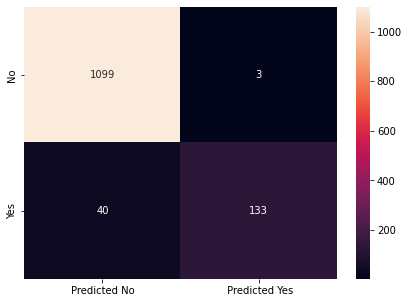

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_new, y, test_size = 0.3, random_state = 0)
lgbm.fit(X_train, y_train)
y_predict = lgbm.predict(X_test)
print(balanced_accuracy_score(y_predict, y_test))

cm=metrics.confusion_matrix(y_test, y_predict,labels=[-1, 1])

df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["Predicted No"," Predicted Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')


### Performance metric table

In [43]:
data = {'Avg. Acc.': avg_acc,
        'Max. Acc': max_acc,
        'AUC-ROC': AUC_ROC,
        'AUC-PR': AUC_PR}

perf_df = pd.DataFrame(data, index=model_name)
print(perf_df.sort_values('Avg. Acc.', ascending=False))

              Avg. Acc.  Max. Acc   AUC-ROC    AUC-PR
LGBM           0.957278  0.981080  0.959877  0.935127
RandomForest   0.947034  0.967891  0.956818  0.928617
Bagging        0.944545  0.964135  0.960421  0.917345
GBoost         0.935686  0.960433  0.950798  0.912894
XGBoost        0.934860  0.954858  0.952948  0.920830
DecisionTree   0.924498  0.975410  0.897702  0.859470
KNN            0.864215  0.888527  0.946467  0.869512
AdaBoost       0.850102  0.904668  0.946762  0.898938


### Hypertuning

In [44]:
from sklearn.model_selection import GridSearchCV
lgbm_pars = { 'reg_lambda': [0,1],
              'learning_rate': [0.03,0.05,0.1], 
              'max_depth': [-1,1,3,5],
              'n_estimators': [50,100,200]}

lgbm_grid = GridSearchCV(lgbm,
                        lgbm_pars,
                        cv = 10,
                        n_jobs = 5,
                        verbose=True,scoring='balanced_accuracy')

lgbm_grid.fit(train_new,y)
print('lgbm',lgbm_grid.best_score_)
print('lgbm',lgbm_grid.best_params_)

rfc_pars = {  
              'max_depth': [0,1,2,3],
              'n_estimators': [50,100,150,200]}

rfc_grid = GridSearchCV(lgbm,
                        rfc_pars,
                        cv = 10,
                        n_jobs = 5,
                        verbose=True,scoring='balanced_accuracy')

rfc_grid.fit(train_new,y)
print('rfc',rfc_grid.best_score_)
print('rfc',rfc_grid.best_params_)



Fitting 10 folds for each of 72 candidates, totalling 720 fits
lgbm 0.9455479452054796
lgbm {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'reg_lambda': 1}
Fitting 10 folds for each of 16 candidates, totalling 160 fits
rfc 0.9445205479452057
rfc {'max_depth': 0, 'n_estimators': 200}


### Stacking

In [45]:
from sklearn.ensemble import StackingClassifier

In [46]:
dtc =  DecisionTreeClassifier(random_state=1)
bgc = BaggingClassifier(n_estimators=200,random_state=1)
rfc = RandomForestClassifier(n_estimators=200,random_state=1)
gbc = GradientBoostingClassifier(n_estimators=200,random_state=1)
xgb = XGBClassifier(n_estimators=200,random_state=1)
lgbm = LGBMClassifier(n_estimators=200,random_state=1)
clf = [('lgbm',lgbm),('gbc',gbc),('xgb',xgb),('bgc', bgc)] #list of (str, estimator)

In [48]:
stack_model = StackingClassifier( estimators = clf,final_estimator = rfc)
score = cross_val_score(stack_model,train_new,y,cv = 10,scoring = 'balanced_accuracy')
print("The final accuracy score is: ",score.mean())

The final accuracy score is:  0.9479452054794522


In [ ]:
test_new.info()

### Creating the submisssion prediction file

In [ ]:
lgbm = LGBMClassifier(learning_rate= 0.05, max_depth= 10, n_estimators= 200, reg_lambda= 1,random_state=1)
lgbm.fit(train_new,y)
final_pred = pd.DataFrame(lgbm.predict(test_new), columns=['churn'])
final_pred["id"] = final_pred.index + 1
cols = ['id', 'churn']
final_pred = final_pred[cols]

In [ ]:
final_pred

,id,churn
0,1,no
1,2,no
2,3,yes
3,4,yes
4,5,yes
...,...,...
745,746,no
746,747,no
747,748,no
748,749,no


In [ ]:
final_pred.to_csv('Pred.csv', index = False)